<a href="https://colab.research.google.com/github/liddlecody/ds2002DataProject1/blob/main/Liddle_DataProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ETL Pipeline

Imports

In [11]:
!pip install balldontlie
import requests
import pandas as pd
import json
import sqlite3
import io
import contextlib
import matplotlib.pyplot as plt
from balldontlie import BalldontlieAPI

%matplotlib inline

Extraction functions

In [12]:
def fetch_all_api_data(api_key, per_page=25, max_calls=20):
    try:
        #instantiate the API client
        api = BalldontlieAPI(api_key=api_key)
        all_players = []
        cursor = None
        call_count = 0

        dummy_out = io.StringIO()

        #retrieve each page of player data until specified limit is hit
        while call_count < max_calls:
            with contextlib.redirect_stdout(dummy_out):
                if cursor is None:
                    response = api.nba.players.list(per_page=per_page)
                else:
                    response = api.nba.players.list(cursor=cursor, per_page=per_page)

            data = response.data
            all_players.extend(data)
            call_count += 1

            meta = response.meta
            next_cursor = getattr(meta, 'next_cursor', None) or (meta.get('next_cursor') if isinstance(meta, dict) else None)

            if not next_cursor or len(data) < per_page:
                break
            cursor = next_cursor

        #convert each item to a dictionary
        all_players_dicts = []
        for item in all_players:
            if not isinstance(item, dict):
                try:
                    item = vars(item)
                except Exception:
                    item = dict(item)
            all_players_dicts.append(item)

        #flatten the list of dictionaries into a dataframa
        df = pd.json_normalize(all_players_dicts)
        print("Fetched API data. Total number of records:", len(df))
        return all_players, df

    except Exception as e:
        print("Error fetching API data:", e)
        return None, pd.DataFrame()

def read_local_csv(file_path):
    #Read a local CSV file into a DataFrame.
    try:
        df = pd.read_csv(file_path)
        print("Successfully read local CSV. Number of records:", len(df))
        return df
    except Exception as e:
        print("Error reading local CSV:", e)
        return pd.DataFrame()


Transformation Functions

In [13]:
#function to add or remove columns from the dataframe
def transform_data(df, add_columns=None, remove_columns=None):
    try:
        if add_columns:
            for col, func_or_value in add_columns.items():
                if callable(func_or_value):
                    df[col] = df.apply(func_or_value, axis=1)
                else:
                    df[col] = func_or_value
        if remove_columns:
            df = df.drop(columns=remove_columns, errors='ignore')
        return df
    except Exception as e:
        print("Error in transforming data:", e)
        return df


def convert_format(df, output_format="csv", output_file="output"):
    try:
        if output_format.lower() == "csv":
            csv_file = output_file + ".csv"
            df.to_csv(csv_file, index=False)
            print(f"Data saved as CSV: {csv_file}")
        elif output_format.lower() == "json":
            json_file = output_file + ".json"
            df.to_json(json_file, orient="records", lines=True)
            print(f"Data saved as JSON: {json_file}")
        else:
            print("Unsupported format. Please choose 'csv' or 'json'.")
    except Exception as e:
        print("Error in converting format:", e)


def merge_data(df1, df2, on_column):
    try:
        merged_df = pd.merge(df1, df2, on=on_column, how="inner")
        print("Successfully merged data.")
        return merged_df
    except Exception as e:
        print("Error merging data:", e)
        return pd.DataFrame()

Analysis Functions

In [14]:
def analyze_data(df):
    import numpy as np
    import matplotlib.pyplot as plt

    #convert height to inches for calculations
    def convert_height_to_inches(height_str):
        try:
            feet, inches = height_str.split('-')
            return int(feet) * 12 + int(inches)
        except Exception:
            return np.nan

    if 'height' in df.columns:
        df['height_in'] = df['height'].apply(convert_height_to_inches)

    #relationship between height and rebounds per game
    if 'height_in' in df.columns and 'trb_per_game' in df.columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(df['height_in'], df['trb_per_game'], alpha=0.7)
        plt.xlabel("Height (inches)")
        plt.ylabel("Total Rebounds per Game")
        plt.title("Relationship Between Height and Rebounds per Game")
        plt.show()

        #compute correlation coefficient
        corr_coef = df[['height_in', 'trb_per_game']].corr().iloc[0, 1]
        print(f"Correlation between height and total rebounds per game: {corr_coef:.2f}")

    #top ten colleges by average points per game
    if 'college' in df.columns and 'pts_per_game' in df.columns:
        college_pts = df.groupby("college")["pts_per_game"].mean().dropna().sort_values(ascending=False)
        top_ten_colleges = college_pts.head(10)
        print("\nTop Ten Colleges by Average Points per Game:")
        print(top_ten_colleges)

        plt.figure(figsize=(10, 6))
        top_ten_colleges.plot(kind='bar', color='skyblue')
        plt.ylabel("Average Points per Game")
        plt.title("Top Ten Colleges by Average Points per Game")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    #average free throw percentage for each position
    if 'position' in df.columns and 'ft_percent' in df.columns:
        position_ft = df.groupby("position")["ft_percent"].mean().dropna().sort_values(ascending=False)
        print("\nAverage Free Throw Percentage by Position:")
        print(position_ft)

        plt.figure(figsize=(8, 5))
        position_ft.plot(kind='bar', color='coral')
        plt.ylabel("Average Free Throw Percentage")
        plt.title("Average Free Throw Percentage by Position")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

Data Storage Function

In [15]:
def load_to_sqlite(df, db_name="etl_data.db", table_name="transformed_data"):
    try:
        #issues with type errors so convert columns that have non-standard types to string
        for col in df.columns:
            if df[col].dtype == 'object' and not df[col].empty:
                sample = df[col].dropna().iloc[0]
                if not isinstance(sample, (int, float, str, bool)):
                    df[col] = df[col].apply(lambda x: str(x))

        conn = sqlite3.connect(db_name)
        df.to_sql(table_name, conn, if_exists="replace", index=False)
        conn.close()
        print(f"Data loaded into SQLite database '{db_name}' from table '{table_name}'.")
    except Exception as e:
        print("Error loading data into SQLite:", e)

Data Summary Functions

In [16]:
def summarize_data(df, description="Data Summary"):
    try:
        print(f"{description}:")
        print("Number of records:", len(df))
        print("Number of columns:", len(df.columns))
    except Exception as e:
        print("Error summarizing data:", e)

Main ETL Pipeline

Extracting data
Fetched API data. Total number of records: 500
Successfully read local CSV. Number of records: 32538
API Data Summary:
Number of records: 500
Number of columns: 14
Local Data Summary:
Number of records: 32538
Number of columns: 35


   id first_name      last_name position height weight jersey_number  \
0   1       Alex        Abrines        G    6-6    190             8   
1   2     Jaylen          Adams        G    6-0    225            10   
2   3     Steven          Adams        C   6-11    265            12   
3   4        Bam        Adebayo      C-F    6-9    255            13   
4   5   DeVaughn  Akoon-Purcell      G-F    6-5    201            44   

           college              country  draft_year  draft_round  \
0     FC Barcelona                Spain      2013.0          2.0   
1  St. Bonaventure                  USA         NaN          NaN   
2       Pittsburgh          New Zealand      2013.0          1.0   
3         Kentucky                  USA      2

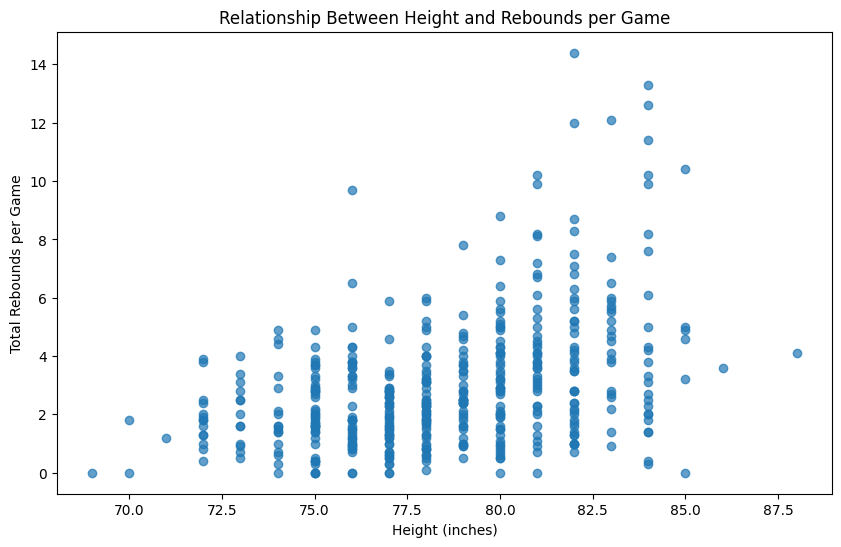

Correlation between height and total rebounds per game: 0.41

Top Ten Colleges by Average Points per Game:
college
Filathlitikos                   30.900000
Weber State                     25.400000
St. Vincent-St. Mary HS (OH)    24.900000
Davidson                        24.000000
Lehigh                          21.900000
Arizona State                   21.700000
Edgewater HS (FL)               18.600000
San Diego State                 17.100000
Mega Basket                     15.500000
Oklahoma                        13.133333
Name: pts_per_game, dtype: float64


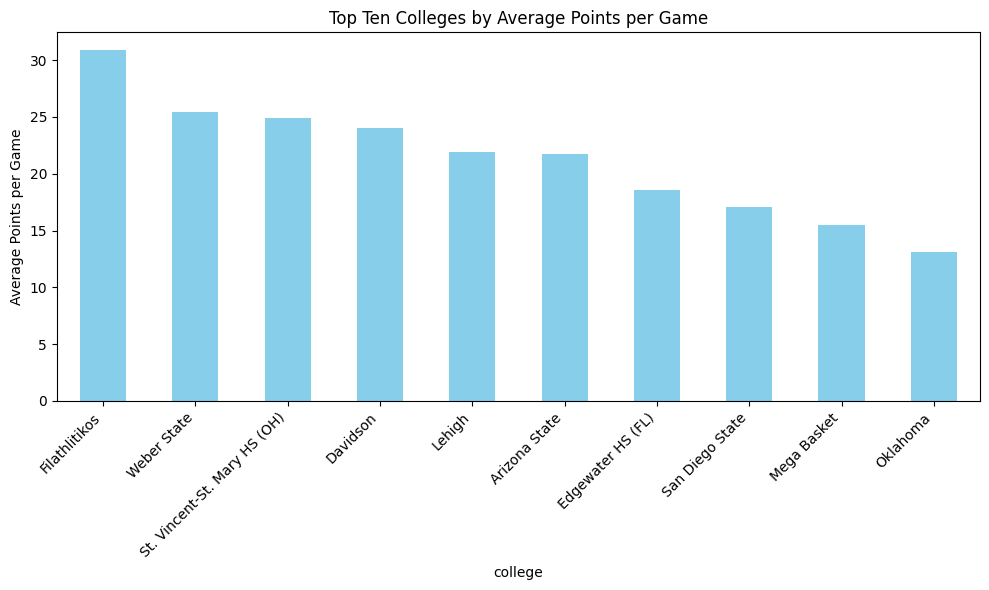


Average Free Throw Percentage by Position:
position
G      0.768949
G-F    0.757037
F-G    0.751222
F-C    0.743273
F      0.718914
C      0.654512
C-F    0.651250
       0.574000
Name: ft_percent, dtype: float64


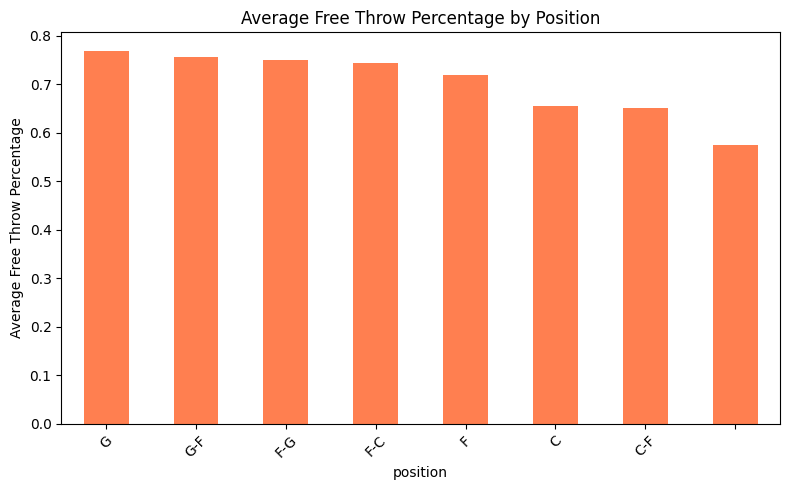


Loading data into SQLite database...
Data loaded into SQLite database 'etl_data.db' from table 'merged_data'.


In [17]:
def main_etl():
    api_key = "6228908f-db75-4479-b8db-ce830d73b106"
    local_csv_path = "nba_stats_kaggle.csv"  #ensure this file is in your working directory

    #Extraction Phase
    print("Extracting data")
    api_raw_data, df_api = fetch_all_api_data(api_key, per_page=25, max_calls=20);
    df_local = read_local_csv(local_csv_path)

    summarize_data(df_api, "API Data Summary")
    summarize_data(df_local, "Local Data Summary")
    print('\n')
    print(df_api.head())
    print(df_local.head())
    print('\n')

    #Transformation Phase
    print("\nTransforming data...")

    #for API data add a 'full_name' column by combining 'first_name' and 'last_name'
    df_api_clean = transform_data(df_api, add_columns={"full_name": lambda row: f"{row['first_name']} {row['last_name']}"}, remove_columns=["draft_year","draft_round","draft_number","team","team_id"])

    #for local data remove unwanted columns
    df_local_clean = transform_data(df_local, remove_columns=["seas_id","player_id","birth_year","lg"])
    #rename column to help with merge later
    df_local_clean.rename(columns={'player': 'full_name'}, inplace=True)
    #take only the most recent season for each player
    df_local_clean['season'] = pd.to_numeric(df_local_clean['season'], errors='coerce')
    df_local_sorted = df_local_clean.sort_values('season', ascending=False)
    df_local_clean = df_local_sorted.drop_duplicates(subset='full_name', keep='first')

    print('\n')
    print(df_local_clean.head())
    print(df_api_clean.head())
    print('\n')


    #Merging Phase
    merged_df = merge_data(df_api_clean, df_local_clean, on_column="full_name")
    print('\nMerged Data')
    summarize_data(merged_df, "Merged Data Summary")
    print('\n')
    print(merged_df.head())

    #convert data into both CSV and JSON formats.
    #change output_format to your desired file type
    convert_format(merged_df, output_format="csv", output_file="merged_data_transformed")
    convert_format(merged_df, output_format="json", output_file="merged_data_transformed")

    #Analysis Phase
    print("\nAnalyzing data...")
    if not merged_df.empty:
        analyze_data(merged_df)
    else:
        print("Merged dataset is empty.")

    #Loading Phase
    print("\nLoading data into SQLite database...")
    load_to_sqlite(merged_df, db_name="etl_data.db", table_name="merged_data")


#execute the ETL pipeline
if __name__ == "__main__":
    main_etl()